In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from scipy import interpolate

import nemplot
from nemplot import nemplot_parameters
import regsim



In [3]:
B_LABEL = r'$B\ped{h}\,[\si{\tesla}]$'
Q_LABEL = r'$\qc\,[\si{\watt}]$'
COP_LABEL = r'$\cop$'
PHI_LABEL = r'$\Phi$'
H_REG_LABEL = r'$H\,[\si{\milli\meter}]$'
F_B_LABEL = r'$F\ped{B}\,[\si{\percent}]$'
F_M_LABEL = r'$F\ped{M}\,[\si{\percent}]$'
H_MAX_LABEL = r'$\mu_0 H\ped{max}\,[\si{\tesla}]$'

N_QC_LEVELS = 10

R_S_MIN = 90
R_S_MAX = 120
R_S_STEP = 5

Q_C_CRITICAL = 72

B_MIN = 1.00
B_MAX = 1.20

# MAGNET DATA
R_O = 40 # [mm]
PHI_S_IV = 45 # [degree]

DICT_LINES = 19

QC_MAPS_FILE = "Slope - Perdas - 35K - Varios H - Parte 2.txt"

In [4]:
FIGSIZE_CM = 15
FONTSIZE = 1.25*FIGSIZE_CM

nemplot.set_latex_font("Times New Roman")
nemplot.set_figsize_cm(FIGSIZE_CM)
nemplot.set_fontsize(FONTSIZE)

In [5]:
def filter_span_to_20K(table):
    """
    Interpolates the given DataFrame 'table' and return a pandas DataFrame, 
    where all the rows have dT_span = 20 K, """
    
    DT = 20
    
    Teste_vector = table_slope_2D['Teste'].unique()
    table = DataFrame()

    sim_row = {}
    
    i_sim = 1
    for teste in Teste_vector:
        
        table_teste = regsim.filter_table_from_column(table,'Teste',teste)

        f_Qc = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['Qc[W]'], fill_value='extrapolate')
        f_COP = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['COP[-]'], fill_value='extrapolate')

        H = table_teste['H[mm]'].values[0]
        Hmax = table_teste['Hmax[T]'].values[0]

        sim_row["Teste"] = teste
        sim_row["H[mm]"] = H
        sim_row["Hmax[T]"] = Hmax
        sim_row["Qc[W]"] = f_Qc(DT)
        sim_row["COP[-]"] = f_COP(DT)

        sim_row_df = DataFrame(sim_row,index=[i_sim,])
        sim_row_df.index.name = "Case"
        table = pd.concat([table,sim_row_df])
        i_sim = i_sim + 1
                
    return table

In [6]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "N_r[]": 10,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "R_o": 0.040,
                "h_fc": 0.005,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

In [7]:
def get_Rs_map_vectors(R_o,phi_S):
    """
    Return (h_gap, B_max, R_s) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm), selecting only the rows
    with dividing angle 'phi_S' [deg]
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with file_path.open() as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["phi_S[deg]",
                   "h_gap[mm]",
                   "B_max[T]",
                    "R_s[mm]",
                   "K[]"] 
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=DICT_LINES,names=column_names,header=0)
    
    map_table = regsim.filter_table_from_column(map_table,'phi_S[deg]',phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,R_s)

In [8]:
(h_gap,B_max,R_s) = get_Rs_map_vectors(40,45)

In [9]:
R_s

array([[  90.,   90.,   90.,   95.,   95.,   95.,  100.,  100.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,   95.,  100.,  105.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,  100.,  100.,  100.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         115.,  115.],
       [  90.,   95.,   95.,  100.,  100.,  100.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  115.,
         115.,  120.],
       [  95.,   95.,   95.,  100.,  105.,  105.,  110.,  11

In [10]:
def plot_Qc_and_Rs_contour():    
    
    table_Qc = pd.read_csv(QC_MAPS_FILE,sep='\t')

    HMax_vector = table_Qc['Hmax[T]'].unique()
    H_reg_vector = table_Qc['H[mm]'].unique()

    Qc_matrix = np.zeros((len(HMax_vector),len(H_reg_vector)))
    COP_matrix = Qc_matrix.copy()
    
    fig_list = []
    table_list = []
    
    fig_Qc, ax_Qc = nemplot.create_plot(title='',
                                        xlabel=H_REG_LABEL,
                                        ylabel=H_MAX_LABEL) 

    Qc_vector = table_Qc['Qc[W]'].values
    COP_vector = table_Qc['COP[-]'].values
    
    #transformando o vetor Qc em matriz
    cont = 0
    for i in range(len(H_reg_vector)):
        for j in range(len(HMax_vector)):                            
            Qc_matrix[j,i] = Qc_vector[cont]
            COP_matrix[j,i] = COP_vector[cont]
            cont += 1
    
    H_reg_grid,B_max_grid = np.meshgrid(H_reg_vector,HMax_vector)
    
    Q_c_min = np.min(Qc_matrix)
    Q_c_max = np.max(Qc_matrix)
    
    # build the Q_c_levels by partinioning the range below and above the critical value,
    # making sure it is included in the list
    Q_c_levels = np.append(np.linspace(Q_c_min,Q_C_CRITICAL,int(N_QC_LEVELS/2),endpoint=False),
                           np.linspace(Q_C_CRITICAL,Q_c_max,int(N_QC_LEVELS/2)))
    
    p_Qc = ax_Qc.contour(H_reg_grid,B_max_grid,Qc_matrix,Q_c_levels,colors='b')
    ax_Qc.clabel(p_Qc,fmt="%d",fontsize=0.9*nemplot_parameters["FONTSIZE"])
    
    # fill the contour between the critical and the maximum value of cooling capacity
    p_Qc_fill = ax_Qc.contourf(H_reg_grid,
                               B_max_grid,
                               Qc_matrix,
                               levels=[Q_C_CRITICAL,Q_c_max,],
                              cmap='Blues')
    
    # load the magnet data
    h_gap_magnet,B_max_magnet,R_s_magnet = get_Rs_map_vectors(R_O,PHI_S_IV)
    H_reg_magnet = h_gap_magnet - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    p_Rs = ax_Qc.contour(H_reg_magnet,
                         B_max_magnet,
                         R_s_magnet,
                         levels=np.arange(R_S_MIN,R_S_MAX + R_S_STEP,R_S_STEP),
                         colors='r')
    ax_Qc.clabel(p_Rs,
                 fmt="%d",
                 fontsize=0.9*nemplot_parameters["FONTSIZE"],
                rightside_up=False)
    
    
    H_reg_min = np.min(H_reg_magnet)
    H_reg_max = np.max(H_reg_magnet)
    dH_reg = 2
    
    H_reg_ticks = np.arange(H_reg_min, H_reg_max + dH_reg, dH_reg)
    
    ax_Qc.set_xlim(np.min(H_reg_magnet),np.max(H_reg_magnet))
    ax_Qc.set_xticks(H_reg_ticks)
    nemplot.refine_xticks(ax_Qc,5)
    
    B_max_min = B_MIN
    B_max_max = B_MAX
    dB_max = 0.05
    
    ax_Qc.set_ylim(B_MIN,B_MAX)
    B_max_ticks = np.arange(B_max_min,B_max_max + dB_max, dB_max)
    ax_Qc.set_yticks(B_max_ticks)
    nemplot.refine_yticks(ax_Qc,5)
    
    fig_list.append(fig_Qc)

    
    nemplot.save_figure(fig_Qc,
                        name='contour_Qc_Rs_W30')

    return fig_list, table_list

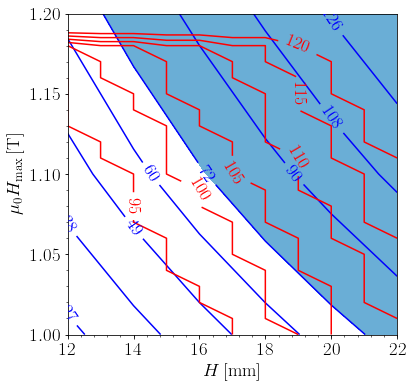

In [11]:
%matplotlib inline

fig_list_slope2D_35K = plot_Qc_and_Rs_contour()